In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from utils import *
from torch.utils.data import Dataset, DataLoader

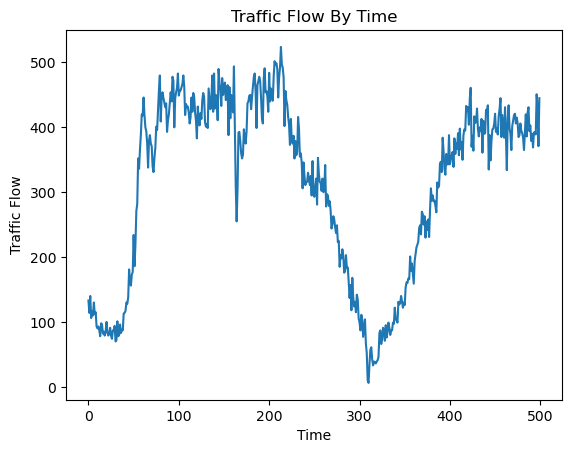

In [5]:
# 数据可视化,以前500次测量为例,省略了部分代码
# plt.plot(data[0:500])
# plt.title("Traffic Flow By Time")
# plt.xlabel("Time")
# plt.ylabel("Traffic Flow")
# plt.show()

In [3]:
# 自定义数据集，用于创建Dataloader
class my_Dataset(Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

In [4]:
# Traffic数据集
class TrafficDataset:
    def __init__(self):
        #只取第一个传感器每5分钟采集到的车流量数据这一个维度来进行预测，其余传感器同理
        self.raw_data = np.load('./dataset/traffic-flow/traffic.npz')['data'][:,0,0]
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.raw_data = (self.raw_data - self.min) / (self.max - self.min)
    # 数据反标准化
    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por,test_por, window_size): 
        # 补全构造过程
        train_data_length=round(len(self.raw_data)*train_por)
        train_set_raw_data=self.raw_data[0:train_data_length]
        train_x=[]
        train_y=[]
        #窗口化处理
        for i in range(train_set_raw_data.shape[0] - window_size + 1):
            train_x.append(train_set_raw_data[i:i+window_size].tolist())
        #每次新进来的数据作为上一个输入数据的输出结果，即“标签”
        for i in range(window_size,len(train_set_raw_data)):
            train_y.append(train_set_raw_data[i].tolist())
        train_x=train_x[:-1]
        
        val_data_length=round(len(self.raw_data)*(train_por+test_por))
        val_set_raw_data=self.raw_data[train_data_length:val_data_length]
        val_x=[]
        val_y=[]
        for i in range(val_set_raw_data.shape[0] - window_size + 1):
            val_x.append(val_set_raw_data[i:i+window_size].tolist())
        for i in range(window_size,len(val_set_raw_data)):
            val_y.append(val_set_raw_data[i].tolist())
        val_x=val_x[:-1]
        
        test_set_raw_data=self.raw_data[val_data_length:]
        test_x=[]
        test_y=[]
        for i in range(test_set_raw_data.shape[0] - window_size + 1):
            test_x.append(test_set_raw_data[i:i+window_size].tolist())
        for i in range(window_size,len(test_set_raw_data)):
            test_y.append(test_set_raw_data[i].tolist())
        test_x=test_x[:-1]

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

In [5]:
#创建数据集
TrafficData=TrafficDataset()

In [6]:
#构造数据
train_set,val_set,test_set=TrafficData.construct_set(0.6,0.2,12)

In [7]:
#升维，便于网络处理
train_set.X=torch.unsqueeze(train_set.X,2)
val_set.X=torch.unsqueeze(val_set.X,2)
test_set.X=torch.unsqueeze(test_set.X,2)

In [8]:
#手动创建RNN网络
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        :param input_size: 指定输入数据的维度。例如，对于简单的时间序列预测问题，每一步的输入均为一个采样值，因此input_size=1.
        :param hidden_size: 指定隐藏状态的维度。这个值并不受输入和输出控制，但会影响模型的容量。
        :param output_size: 指定输出数据的维度。此值取决于具体的预测要求。例如，对简单的时间序列预测问题，output_size=1.
        """
        super().__init__()
        self.hidden_size = hidden_size
        
        # 可学习参数的维度设置，可以类比一下全连接网络的实现。其维度取决于输入数据的维度，以及指定的隐藏状态维度。
        self.w_h = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
        self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))
        
        # 准备激活函数。Dropout函数可选。
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU()
        
        # 可选：使用性能更好的参数初始化函数
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        """
        :param x: 输入序列。一般来说，此输入包含三个维度：batch，序列长度，以及每条数据的特征。
        """
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # 初始化隐藏状态，一般设为全0。由于是内部新建的变量，需要同步设备位置。
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        # RNN实际上只能一步一步处理序列。因此需要用循环迭代。
        y_list = []
        for i in range(seq_len):
            h = self.tanh(torch.matmul(x[:, i, :], self.w_h) + 
                             torch.matmul(h, self.u_h) + self.b_h)  # (batch_size, hidden_size)
            y = self.leaky_relu(torch.matmul(h, self.w_y) + self.b_y)  # (batch_size, output_size)
            y_list.append(y)
        # 一般来说，RNN的返回值为最后一步的隐藏状态，以及每一步的输出状态。
        return torch.stack(y_list, dim=1), h

In [9]:
device = 'mps'  # MacOS
batch_size = 32
seq_len = 12
input_size = 2
hidden_size = 32
output_size = 1

x = torch.rand(batch_size, seq_len, input_size).to(device)
rnn = MyRNN(input_size, hidden_size, output_size).to(device)
hidden, y = rnn(x)
print(hidden.shape, y.shape)

torch.Size([32, 12, 1]) torch.Size([32, 32])


In [10]:
#封装DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

In [11]:
#设置超参数
device = torch.device("mps")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)

optimizer = torch.optim.Adam(my_rnn.parameters(), lr)

In [12]:
#评估函数
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [13]:
#训练
train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.0147, train rmse 55.9098, val loss 0.0028, val rmse 32.253209, time use 4.055s
*** epoch2, train loss 0.0022, train rmse 29.8158, val loss 0.0024, val rmse 29.998086, time use 3.913s
*** epoch3, train loss 0.0020, train rmse 28.3517, val loss 0.0023, val rmse 29.328176, time use 3.915s
*** epoch4, train loss 0.0019, train rmse 27.6689, val loss 0.0022, val rmse 28.818703, time use 3.913s
*** epoch5, train loss 0.0018, train rmse 27.1487, val loss 0.0023, val rmse 29.412237, time use 3.882s
*** epoch6, train loss 0.0018, train rmse 27.0165, val loss 0.0021, val rmse 28.247436, time use 3.825s
*** epoch7, train loss 0.0018, train rmse 26.9224, val loss 0.0021, val rmse 28.274240, time use 3.826s
*** epoch8, train loss 0.0018, train rmse 26.7306, val loss 0.0024, val rmse 30.115352, time use 3.850s
*** epoch9, train loss 0.0018, train rmse 26.5642, val loss 0.0021, val rmse 28.103900, time use 3.847s
*** epoch10, train loss 0.0017, train rmse 26.3491, val loss 0.0

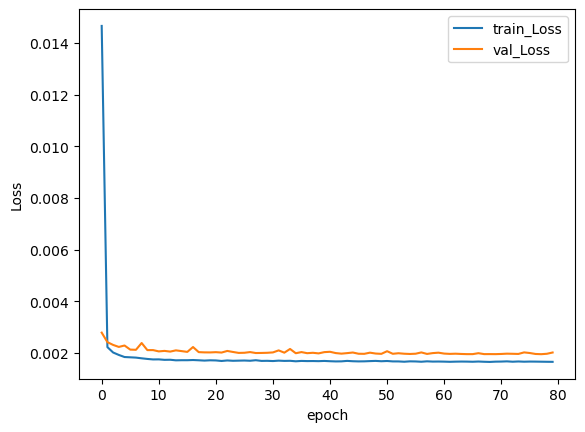

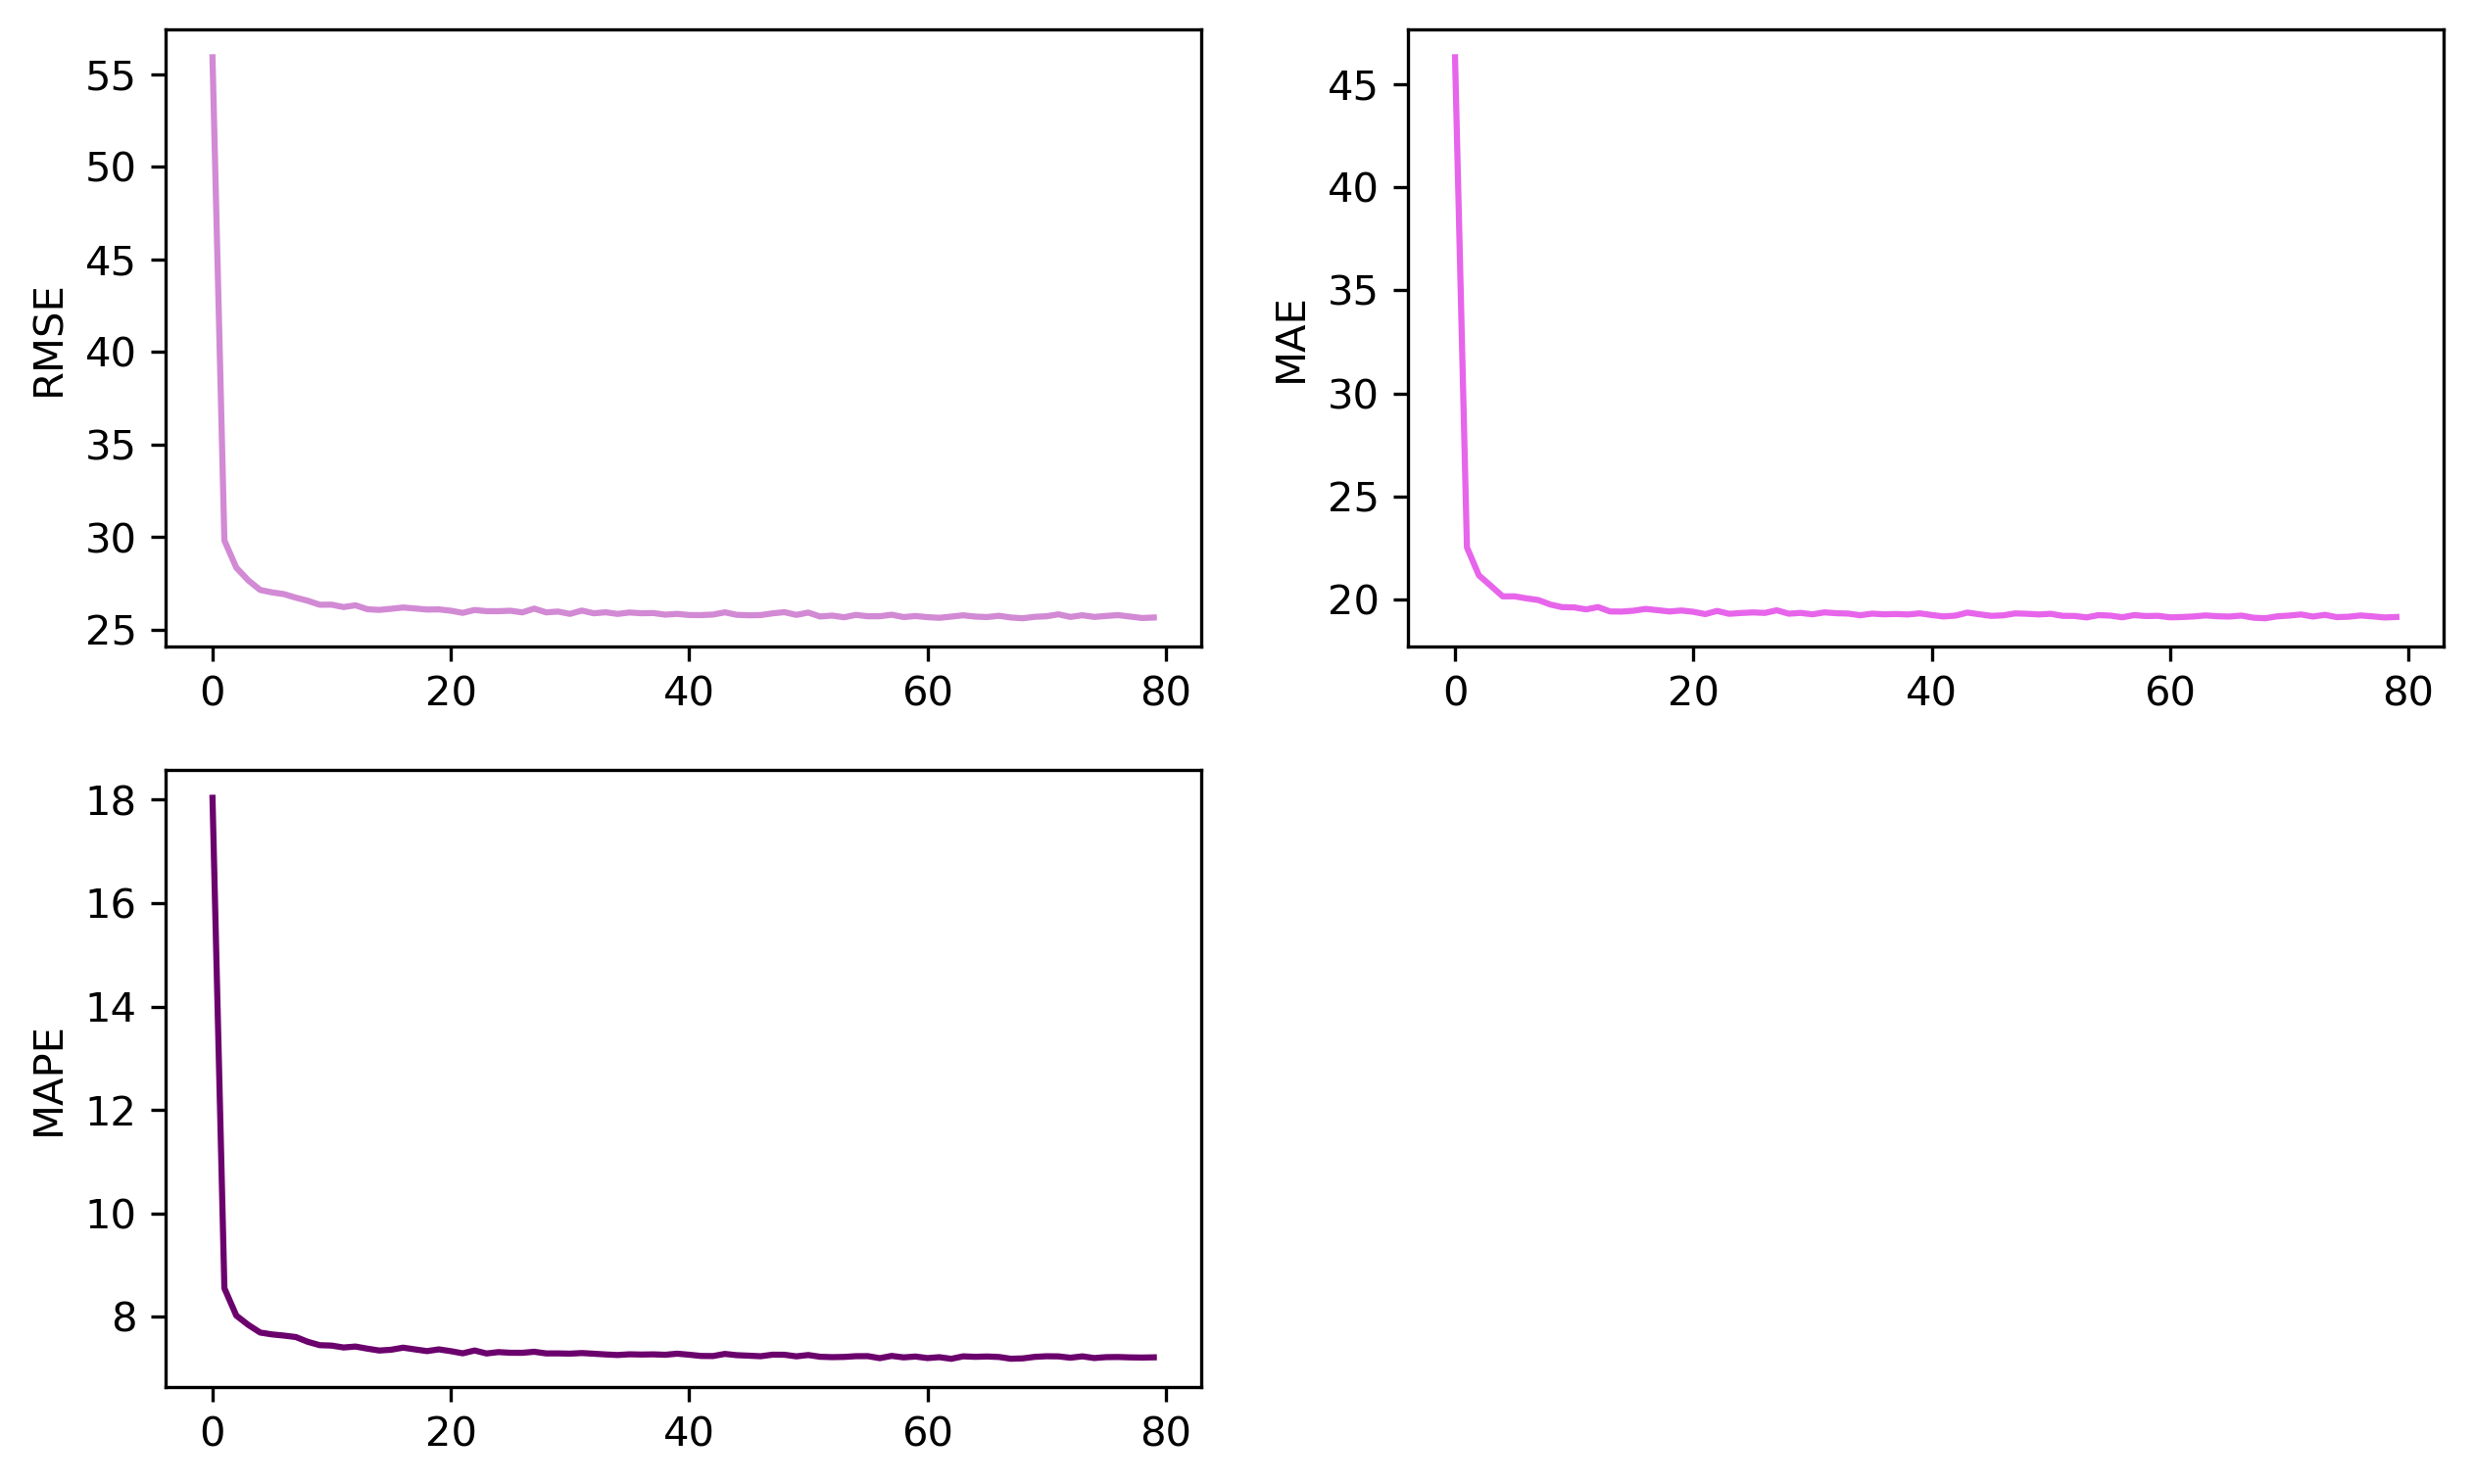

In [15]:
#模型结果可视化
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)